# **Introductions**

This notebook explores which features meaningfully contribute to eviction risks, focusing on how SVI (Social Vulnerability Index), building characteristics, and tenant complaint behavior influence eviction severity—both independently and interactively. (Currently, the analysis includes only SVI and building-related features using the cleaned and merged dataset.)

From previous analyses, we’ve seen that linear or even multilinear models struggle to capture the complex relationships between the various input features and eviction rates. Here, we demonstrate how and why non-linear, tree-based models (e.g., Decision Trees and Random Forests) can help uncover more nuanced patterns and identify the features that matter most.

(due to length, we will continue the shap and dpd in the following notebook)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import datetime
import shap
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = "/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times.csv"

In [5]:
df_raw = pd.read_csv(file_path)

In [6]:
df = df_raw.copy()

In [7]:
df.columns

Index(['primary_key', 'bbl', 'court_index_number', 'docket_number',
       'eviction_address', 'eviction_apartment_number', 'executed_date',
       'borough', 'zipcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'nta', 'year', 'month_year', 'geometry',
       'average_year_eviction_count', 'yearbuilt', 'bldgclass', 'numfloors',
       'unitsres', 'ownername', 'bldgarea', 'building_type',
       'building_category', 'is_condo', 'floor_category', 'rent_era',
       'architectural_style', 'economic_period', 'residential_units_category',
       'is_llc', 'building_size_category', 'size_quartile', 'decade', 'fips',
       'e_totpop', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4',
       'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
       'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh',
       'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian',

# **Part 1: If there is no strong linear relationships between SVI data and the eviction rate, what non-linear relationships could these svi measurements have with the eviction rate (per year, per building)?**

**Part 1.1 Spearsman rank correlation: good for detecting and measuring monotonic relationships even if not linear nor normally distributed.**

In [8]:
df_svi = df.copy()

In [9]:
svi_vars = ['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4', 'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
  'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh', 'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian', 'ep_aian',
  'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white', 'svi_quartile']

In [10]:
df_svi.svi_quartile.unique()
# these are strings, and will not work with the analysis.

array(['Q3', 'Q4 (High)', 'Q2', 'Q1 (Low)'], dtype=object)

In [11]:
df_svi.svi_quartile = df_svi.svi_quartile.str.extract(r'Q(\d)').astype(int)

In [12]:
df_svi.svi_quartile.unique(), df_svi.svi_quartile[0].dtype

(array([3, 4, 2, 1]), dtype('int64'))

In [13]:
check_nan = df_svi[['average_year_eviction_count'] + svi_vars].isna().sum()
check_nan
# just in case, check nans

,0
average_year_eviction_count,0
rpl_theme1,0
rpl_theme2,0
rpl_theme3,0
rpl_theme4,0
rpl_themes,0
ep_pov150,0
ep_unemp,0
ep_nohsdp,0
ep_uninsur,0


In [14]:
df_spearman = df_svi[['average_year_eviction_count'] + svi_vars]
# corret way to combine columns, saving space

In [15]:
corr_matrix = df_spearman.corr(method='spearman')

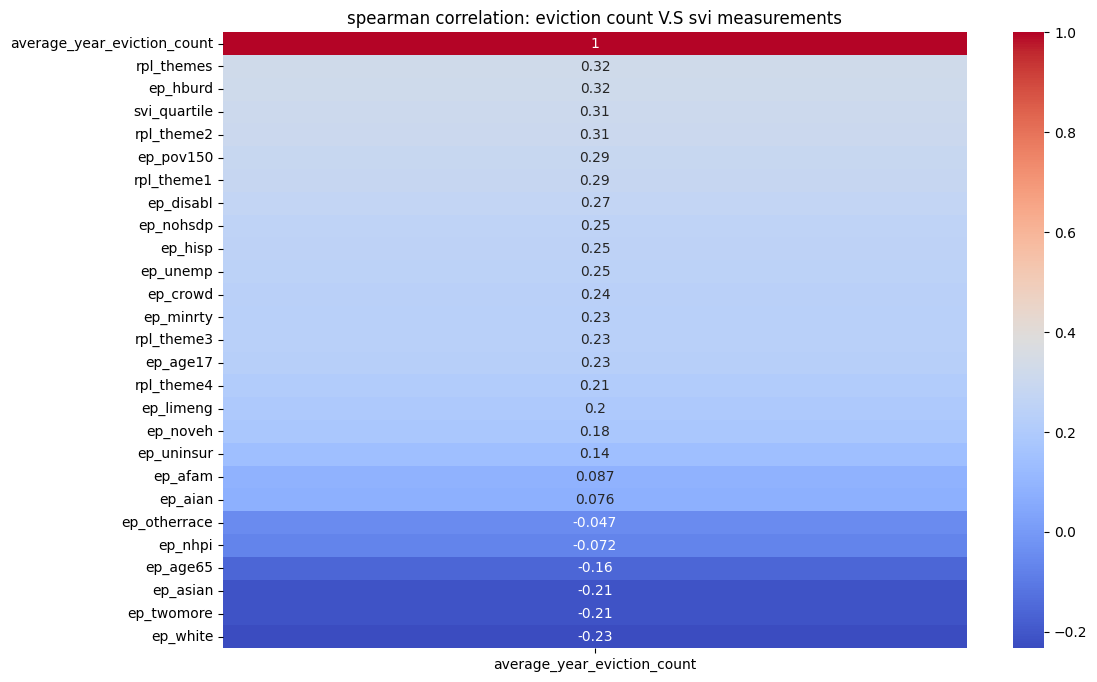

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['average_year_eviction_count']].sort_values(by='average_year_eviction_count', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count V.S svi measurements')
plt.show()

**What this chart is showing:**

**The SVI measurements showing the strongest positive correlations with eviction counts are:**

rpl_themes (0.32): overall themes of social vulnerability \
ep_hburd (0.32): housing burden \
svi_quatile (0.31): the quartile svi falls into \
rpl_theme2 (0.31): household composition and disability \
ep_pov150 (0.29): poverty measures \
rpl_theme1 (0.29): low income measures \

**moderate positive correlations (0.23-0.27) exist with:** \

ep_disabl: disability \
ep_nohsdp: no high school diploma \
ep_hisp: hispanic population \
ep_unemp: unemployment \
ep_crowd: crowded housing \
ep_minrty: minority populations \

**strongest negative correlations are shown with:**

ep_white (-0.23): white population percentage
ep_twomore (-0.21): two or more races
ep_asian (-0.21): Asian population
ep_age65 (-0.16): population over 65

**what this suggests:**

1. Evictions are more frequent in areas with higher **social vulnerability housing burden** and **household composition factors** have the strongest relationship with evictions
2. areas with higher percentages of white and Asian populations tend to have fewer evictions
3. areas with older populations (65+) have slightly fewer evictions

**Part 1.2 Mutural information scores: measuring non-linear dependencies between features, and is good for discovering how much information one variable gives about another.**

In [17]:
df_svi.isna().sum().sum()
# just double checking

np.int64(0)

In [18]:
X = df_svi[svi_vars]
y = df_svi['average_year_eviction_count']

mi_scores = mutual_info_regression(X, y)

In [19]:
mi_df = pd.DataFrame({'svi_measurements': svi_vars, 'mi_scores': mi_scores})
mi_df = mi_df.sort_values(by='mi_scores', ascending=False)

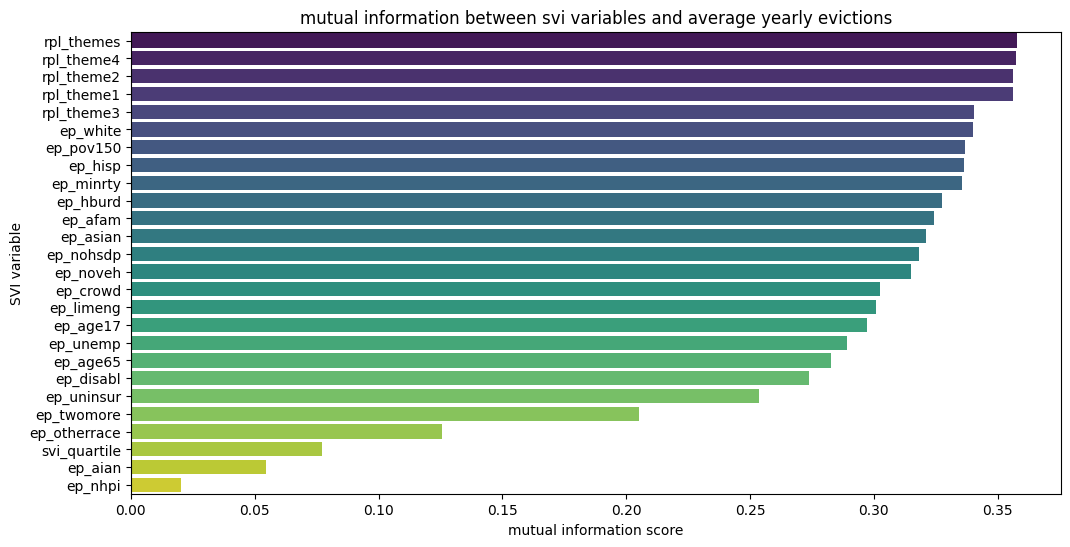

In [20]:
plt.figure(figsize=(12,6))
sns.barplot(data=mi_df, x='mi_scores', y='svi_measurements', palette='viridis')
plt.title("mutual information between svi variables and average yearly evictions")
plt.xlabel("mutual information score")
plt.ylabel("SVI variable")
plt.show()

**Interestingly, the white population seems be have a larger mutual information scores than what we have learned from linear model. Some ofther key insight from this graph is that the composite theme scores, especially those related to socioeconomic status, housing, and transportation, are the most informative predictors of eviction counts, while specific racial/ethnic categories (particularly those with smaller population percentages) provide less information overall**

In [21]:
X_svi = df[svi_vars]

In [22]:
svi_quartile_map = {
    'Q1 (Low)': 1,
    'Q2': 2,
    'Q3': 3,
    'Q4 (High)': 4
}
X_svi['svi_quartile_num'] = X_svi['svi_quartile'].map(svi_quartile_map)

In [23]:
X_svi.svi_quartile_num.unique()

array([3, 4, 2, 1])

In [26]:
X_svi.drop('svi_quartile', axis=1, inplace=True)

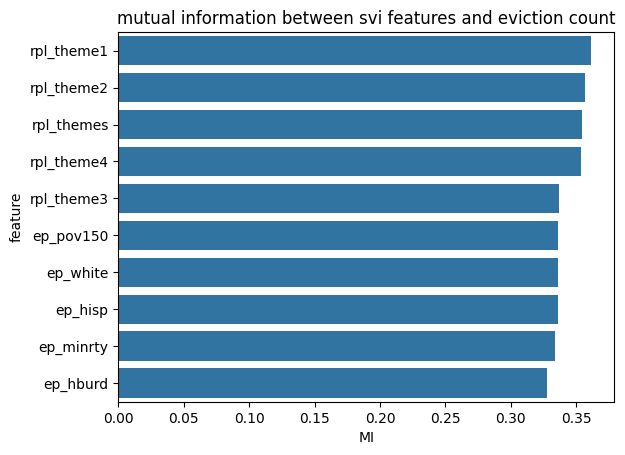

In [27]:
mi_scores = mutual_info_regression(X_svi, df_svi['average_year_eviction_count'])

mi_df = pd.DataFrame({'feature': X_svi.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False)
sns.barplot(data=mi_df.head(10), x='MI', y='feature')
plt.title("mutual information between svi features and eviction count")
plt.show()
# we will go into details after we run random forest regressor below

In [28]:
# y = df['average_year_eviction_count']
# X_svi = df_svi[svi_vars].copy()
# X_train_svi, X_test_svi, y_train, y_test = train_test_split(X_svi, y, test_size=0.2, random_state=42)
# model_svi = RandomForestRegressor(n_estimators=100, random_state=42)
# model_svi.fit(X_train_svi, y_train)

In [29]:
# # top 6
# top_svi_features = ['rpl_themes', 'rpl_theme1', 'rpl_theme4', 'rpl_theme2', 'ep_pov150', 'ep_white']

# PartialDependenceDisplay.from_estimator(
#     model_svi,
#     X_svi,
#     top_svi_features,
#     kind='average',
#     # pdp
#     grid_resolution=100
# )
# plt.suptitle("partial dependence of top SVI 6 features on eviction count", fontsize=14)
# plt.tight_layout()
# plt.show()
# # ep_pov150: percentage of people below 150% of the federal poverty line
# # see after we ran rfr, and we will get the 10 factors below

In [30]:
# PartialDependenceDisplay.from_estimator(
#     model_svi,
#     X_svi,
#     ['ep_pov150'],
#     kind='both',
#     grid_resolution=100
# )
# plt.title("PDP + ICE for poverty level (ep_pov150)")
# plt.tight_layout()
# plt.show()
# # will see later.

**Part 1.3 we will use a decision tree regressor to rank SVI variables by how much they reduce impurity in predicting eviction counts (again, in general, they work well for non-linear relationships, and we aim to find a few features that may be different from what linear regression told us.).**

results are not as good/clear as we thought. It may not be good for this analysis as DT usually is sensitive to noisy data and variances, which is the case for eviction rates and many features. Currently, we will not go into this graph, as the most telling one at this moment should be RandomForest and PDP results, because we want to to know how each feature actually affect the eviction rates.

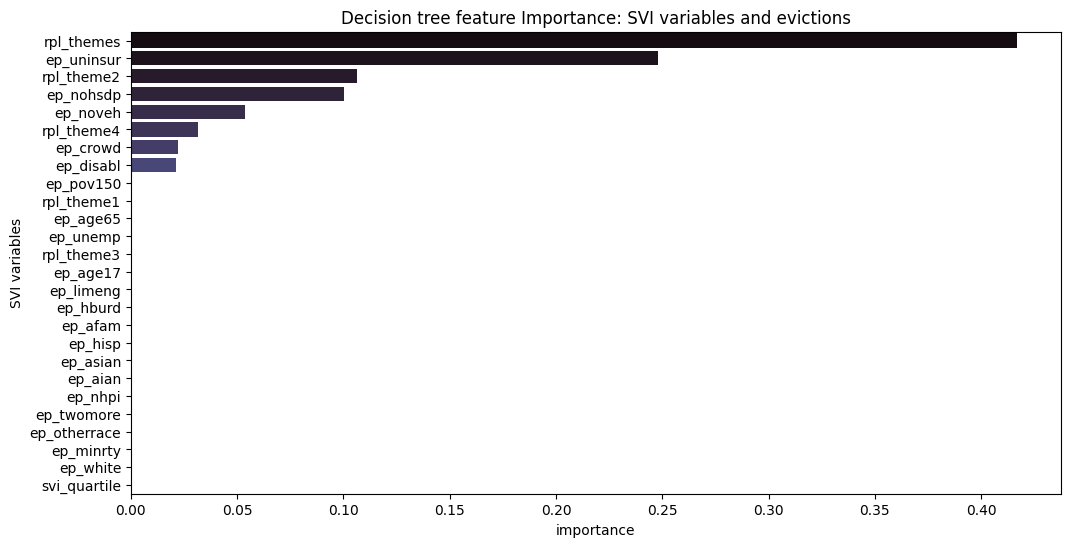

In [31]:
tree_model_svi = DecisionTreeRegressor(max_depth=4)
tree_model_svi.fit(X, y)
importances = tree_model_svi.feature_importances_

imp_df = pd.DataFrame({'SVI variables': svi_vars, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=imp_df, x='importance', y='SVI variables', palette='mako')
plt.title("Decision tree feature Importance: SVI variables and evictions")
plt.show()

**Part 1.4 RandomForestRegressor analysis + PDP**

In [32]:
X = df_svi[svi_vars]
y = df_svi['average_year_eviction_count']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [35]:
y_pred = model_rfr_svi.predict(X_test)
df_svi['predicted_eviction_count'] = model_rfr_svi.predict(X)

In [36]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"mse {mse:.2f}, r square {r2:.2f}")
# not so good predictive value for building features and eviction rates, but we will see what we can do with the features

mse 4.45, r square 0.08


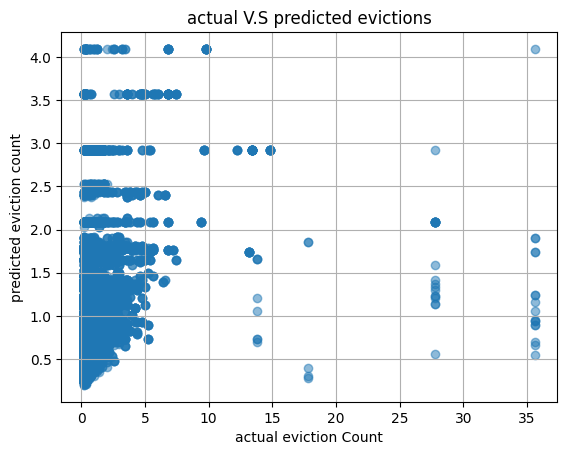

In [37]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("actual eviction Count")
plt.ylabel("predicted eviction count")
plt.title("actual V.S predicted evictions")
plt.grid(True)
plt.show()

**This shows the random forest regressor does not perform very well in predicting eviction counts with the svi data. Not surprised, given the complex social dynamics behind evictions, which likely extend beyond the SVI. However, RFR still can capture how each factor contributes to the eviction rate in their own ways (non-linear).**

In [38]:
# all models below but above the next section will be RFR
feat_importances = pd.Series(model_rfr_svi.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

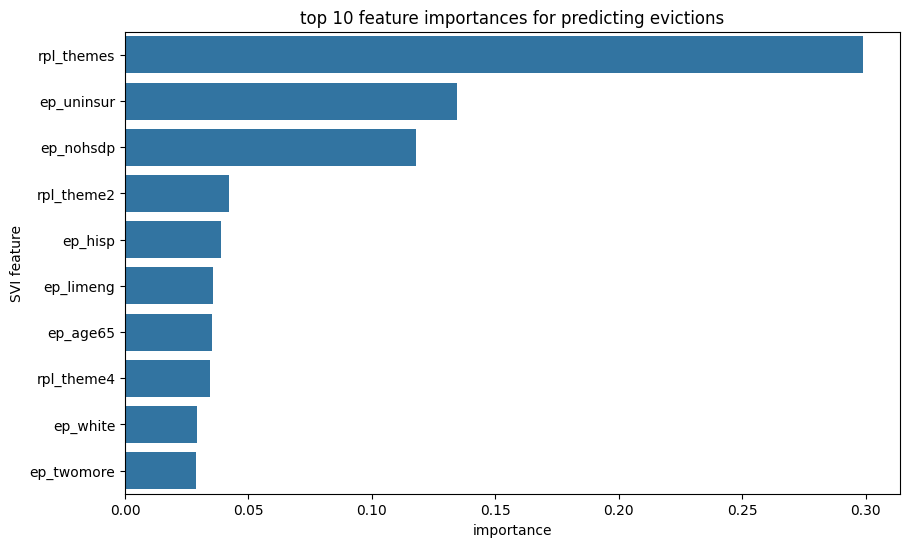

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values[:10], y=feat_importances.index[:10])
plt.title("top 10 feature importances for predicting evictions")
plt.xlabel("importance")
plt.ylabel("SVI feature")
plt.show()

In [40]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [svi_vars[i] for i in top_features_idx]

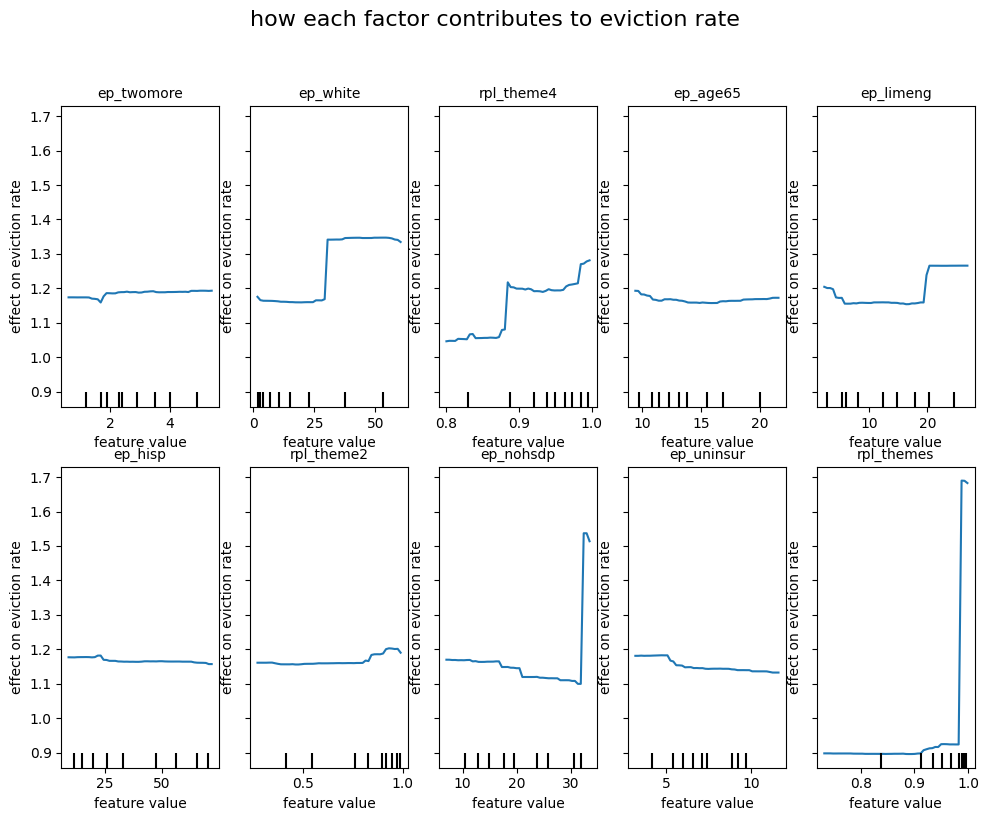

In [41]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

- ep_twomore (households with 2+ units sharing housing):
Generally has a positive effect, slightly above 1.2. More such households ---> higher eviction rate.
- ep_white (proportion of white population):
nonlinear jump: At around 20–25%, a sharp increase in eviction rate effect is observed. areas with a sudden increase in White population may experience higher predicted eviction rates.
- rpl_theme4 (a theme in the Social Vulnerability Index):
gradual increase in eviction rate with higher scores, especially after ~0.9. It suggests vulnerability theme 4 has a compounding negative effect.
- ep_age65 (percent of population 65+):
negative correlation: more elderly population tends to reduce predicted eviction rate slightly.
- ep_limeng (limited english proficiency):
noticeable jump near value 20 leads to sharp increase in predicted eviction. linguistic barriers might correlate with housing instability.
- ep_hisp (percent hispanic):
Slight upward trend ---> modest increase in eviction rate with increasing Hispanic population proportion.
- rpl_theme2 (another vulnerability theme):
Fairly flat, small rise past 0.9, but not very strong overall influence.
- ep_nohsdp (percent without high school diploma):
Effect increases gradually, then jumps after ~30. Strong correlation: lower education attainment ---> higher eviction risk.
- ep_uninsur (uninsured population):
mostly flat or slightly negative: may not significantly affect eviction in the model.
- rpl_themes (overall vulnerability index):
Sharp spike after 0.95. It suggests very high social vulnerability leads to a steep increase in eviction risk.

In [42]:
df_building = df.copy()

In [43]:
df_building.floor_category.unique()

array(['low-rise', 'mid-rise', 'high-rise'], dtype=object)

# **Part 2: Check linearity and Tree-based nonlinear models with eviction rates and building features**

## **Part 2.1 Spearsman rank correlation: good for detecting and measuring monotonic relationships even if not linear nor normally distributed.**

In [44]:
building_vars = ['yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea', 'building_type', 'building_category', 'is_condo',
'floor_category', 'rent_era', 'architectural_style', 'residential_units_category', 'is_llc', 'building_size_category',
'size_quartile', 'decade',]

### **Since many of these columns are strings, not numeric, we will convert them to numerics based on their properties. We will examine these features case by case.**

1. These categories can be removed: because they have had original columns that had numeric datatypes and was abstrcted to be categorical ones: decade, rent_era, economic_period. \

2. These columns do not make much sense to be used for regression analysis: ownername.

3. Binary-encoding: is_condo, is_llc.

4. Ordinal encodings: floor_category, residential_units_category, building_size_category, size_quartile,

5. Nominal categories: building_type, architectural_style [because they do not have natural orders; in this case, we will use one-hot encoding].

6. Nominal categories (label encoding, because we just need arbitrary labels):  bldgclass [actually, this was done already by nature, but we will re-label them so they do not seem too arbitrary.]

7. Temporal-based --> make them into ages: yearbuilt ->  20 (years old).

In [45]:
df_building.architectural_style.unique()

array(['1921–1930, Art Deco Skyscrapers', '1900–1920, Beaux-Arts',
       '1951–1980, the International Style, Alternative Modernism',
       '1931–1950, Manhattan Modern', '1981–2000, Post-Modernism',
       '2001-present, New Architecture', 'Pre-1900'], dtype=object)

In [46]:
df_building.size_quartile[0]

'Q3 (50-75%)'

In [47]:
floats = ['yearbuilt', 'numfloors', 'unitsres', 'bldgarea']
df_building.yearbuilt[0].dtype, df_building.numfloors[0].dtype, df_building.unitsres[0].dtype, df_building.bldgarea[0].dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [48]:
# other columns' types
type(df_building.building_type[0]), type(df_building.architectural_style[0]), type(df_building.bldgclass[0]), type(df_building.building_category[0]), type(df_building.is_condo[0]), \
type(df_building.is_llc[0]), type(df_building.residential_units_category[0]), type(df_building.building_size_category[0]), type(df_building.size_quartile[0]), type(df_building.decade[0])

(str, str, str, str, numpy.bool, numpy.bool, str, str, str, str)

In [49]:
df_building.building_type[0], df_building.building_category[0]
# different types of categorizations, just to make sure

('pre-war', 'walk-up')

In [50]:
df_building.residential_units_category.unique()

array(['3-5 units', '2-unit', '100+ units', '21-100 units', 'single-unit',
       '6-20 units'], dtype=object)

In [51]:
# let's do binary encoding first
binary_vars = ['is_condo', 'is_llc']
for var in binary_vars:
    if var in df.columns:
        df_building[var] = df_building[var].astype(int)

In [52]:
# ordinal encoding, choose the mid-points of those ranges
# to reserve orders
residential_unit_mapping = {
    'single-unit': 1,
    '2-unit': 2,
    '3-5 units': 4,
    '6-20 units': 13,
    '21-100 units': 60,
    '100+ units': 150
}

In [53]:
df_building['residential_units_category'] = df_building['residential_units_category'].map(residential_unit_mapping)

In [54]:
# df[df['residential_units_category'] >= 100]
df_building.floor_category.unique(), df_building.building_size_category.unique(), df_building.size_quartile.unique()

(array(['low-rise', 'mid-rise', 'high-rise'], dtype=object),
 array(['small', 'very small', 'medium-small', 'mega', 'very large',
        'large', 'medium', 'tiny'], dtype=object),
 array(['Q3 (50-75%)', 'Q1 (smallest 25%)', 'Q4 (largest 25%)',
        'Q2 (25-50%)'], dtype=object))

In [55]:
size_mapping = {
    'tiny': 1,
    'very small': 2,
    'small': 3,
    'medium-small': 4,
    'medium': 5,
    'large': 6,
    'very large': 7,
    'mega': 8
}

In [56]:
df_building['building_size_category'] = df_building['building_size_category'].map(size_mapping)

In [57]:
floor_category_mapping = {'low-rise': 1, 'mid-rise': 2, 'high-rise': 3}
df_building['floor_category'] = df_building['floor_category'].map(floor_category_mapping)

In [58]:
size_quartile_mapping = {'Q1 (smallest 25%)': 1, 'Q2 (25-50%)': 2, 'Q3 (50-75%)': 3, 'Q4 (largest 25%)': 4}
df_building['size_quartile'] = df_building['size_quartile'].map(size_quartile_mapping)

In [59]:
df_building.building_type.nunique(), df_building.architectural_style.nunique(), df_building.bldgclass.nunique()

(2, 7, 48)

In [60]:
df_building.bldgclass.unique()
# these actually do not have any meanings after all, were used to make sure they are all residential buildings
# here, they are all residential buildings, some as apartments, conods, and some as mixed....
# so we will not do anything to this column name and not use them for this type of analysis

array(['C0', 'B2', 'C3', 'D4', 'D7', 'D1', 'C1', 'C2', 'D3', 'A5', 'R1',
       'A1', 'B1', 'D9', 'D6', 'S2', 'C7', 'R4', 'C4', 'D5', 'R2', 'C6',
       'B3', 'A2', 'C9', 'R3', 'S4', 'S3', 'B9', 'C5', 'S9', 'S5', 'D2',
       'D8', 'A9', 'S1', 'A4', 'RR', 'A8', 'A0', 'A6', 'R9', 'D0', 'R5',
       'S0', 'A7', 'A3', 'C8'], dtype=object)

In [61]:
# since building type only has 2 types, we will just
# convert 'pre-war' --> 0, 'post-war' --> while keeping column name
# also binary enconding
df_building['building_type'] = (df_building['building_type'] == 'post-war').astype(int)

In [62]:
df_building['building_age'] = pd.Timestamp.now().year - df_building['yearbuilt']

In [63]:
# architectural style naturally and certainly is good for label encoding,
# but for regression, we will use 1-7, aka ordinal encoding
# to avoid bias, we will also use frequency encoding to form another column,
# we will add new columns to account for these three different types of encoding to
# avoid confusion and only use the good columns whenever necessary
era_order = {
    'Pre-1900': 1,
    '1900–1920, Beaux-Arts': 2,
    '1921–1930, Art Deco Skyscrapers': 3,
    '1931–1950, Manhattan Modern': 4,
    '1951–1980, the International Style, Alternative Modernism': 5,
    '1981–2000, Post-Modernism': 6,
    '2001-present, New Architecture': 7
}

In [64]:
df_building['style_ordinal'] = df_building['architectural_style'].map(era_order)

In [65]:
# frequence encoding
style_freq = df_building['architectural_style'].value_counts(normalize=True)
df_building['style_freq'] = df_building['architectural_style'].map(style_freq)

In [66]:
# label encoding
df_building['style_label'] = LabelEncoder().fit_transform(df['architectural_style'])

In [67]:
# df_building.columns

In [68]:
# for building category, we will also use these all three types of encoding and only use them whenever necessary
df_building.building_category.unique()

array(['walk-up', 'two-family', 'condo-co-op', 'elevator',
       'single-family', 'primarily_res_with_mixed_use'], dtype=object)

In [69]:
ordinal_mapping = {
    'single-family': 1,
    'two-family': 2,
    'walk-up': 3,
    'primarily_res_with_mixed_use': 4,
    'condo-co-op': 5,
    'elevator': 6
}
# only good for regression

In [70]:
df_building['building_category_ordinal'] = df_building['building_category'].map(ordinal_mapping)

In [71]:
# using frequency encoding
freq = df_building['building_category'].value_counts(normalize=True)
df_building['building_category_freq'] = df_building['building_category'].map(freq)
# to have the most diverse set of values assigned to them to avoid bias

In [72]:
# freq = df['building_category'].value_counts(normalize=True)

In [73]:
df_building['building_category_le'] = LabelEncoder().fit_transform(df_building['building_category'])
# label encoding: good for random forest or XGBoost

In [74]:
new_building_vars = ['numfloors', 'building_category_ordinal', 'unitsres', 'bldgarea', 'building_type', 'is_condo', 'is_llc',
  'style_ordinal', 'building_age', 'floor_category', 'size_quartile', 'building_size_category', 'residential_units_category']

In [75]:
df_building[new_building_vars].head()
# all numeric columns, except the frequency counts and the label encoding ones, as they are not suitable for linear
# regression anyways, so I did not include them here. Will be utilized in other places later.

,numfloors,building_category_ordinal,unitsres,bldgarea,building_type,is_condo,is_llc,style_ordinal,building_age,floor_category,size_quartile,building_size_category,residential_units_category
0,3.0,3,3.0,2700.0,0,0,1,3,95.0,1,3,3,4
1,2.0,2,2.0,1204.0,0,0,1,2,105.0,1,1,2,2
2,4.0,3,4.0,4800.0,0,0,0,2,118.0,2,4,4,4
3,21.0,5,352.0,381213.0,1,1,0,5,58.0,3,4,8,150
4,6.0,6,65.0,69102.0,0,0,1,3,97.0,2,4,7,60


In [76]:
check_nan = df_building[['average_year_eviction_count'] + new_building_vars].isna().sum()
check_nan
# just in case, check nans

,0
average_year_eviction_count,0
numfloors,0
building_category_ordinal,0
unitsres,0
bldgarea,0
building_type,0
is_condo,0
is_llc,0
style_ordinal,0
building_age,0


In [77]:
target_and_features = ['average_year_eviction_count'] + new_building_vars
df_spearman = df_building[target_and_features].copy()

In [78]:
spearman_corr = df_spearman.corr(method='spearman')['average_year_eviction_count'].sort_values(ascending=False)
spearman_corr

,average_year_eviction_count
average_year_eviction_count,1.000000
unitsres,0.569820
bldgarea,0.563387
building_size_category,0.559404
residential_units_category,0.546332
numfloors,0.530388
floor_category,0.497768
building_category_ordinal,0.452105
size_quartile,0.336429
style_ordinal,0.221469


In [79]:
# df_spearman = df_building['average_year_eviction_count'] + df_building[new_building_vars]
# # this line would use up ram very quickly,because this is creating unnecessary intermediate DataFrames when concatenating columns
# # not the correct way to combine columns (it tries to add values instead of merging columns).

In [80]:
# df[new_building_vars].head()
# # all numeric values

In [81]:
corr_matrix = df_spearman.corr(method='spearman')

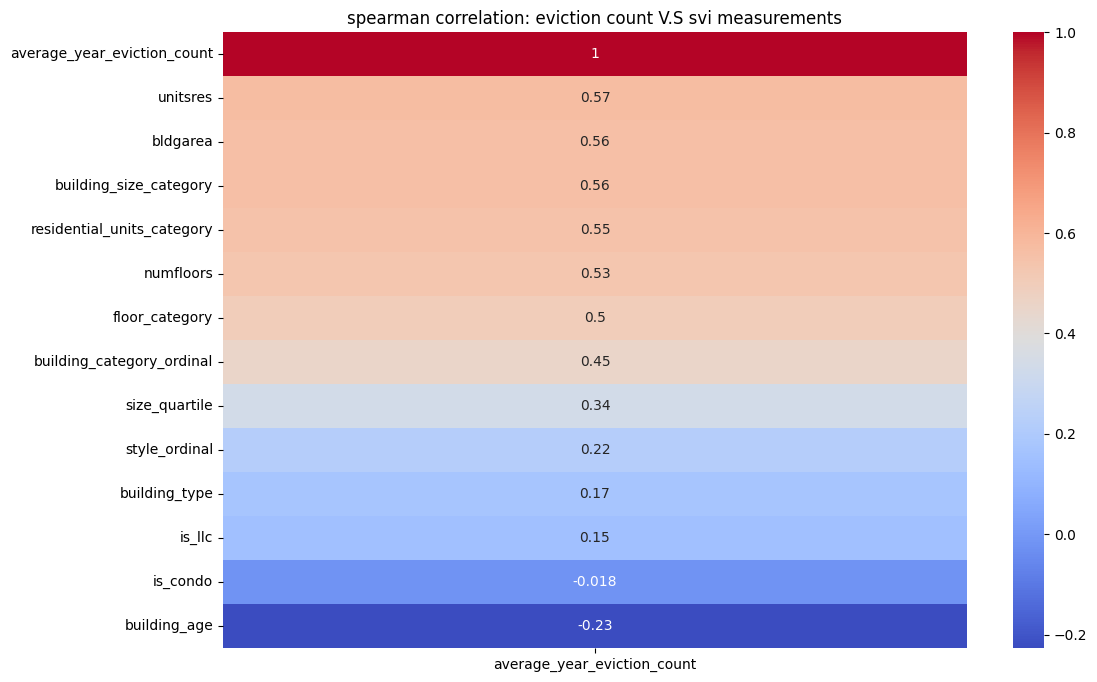

In [82]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['average_year_eviction_count']].sort_values(by='average_year_eviction_count', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count V.S svi measurements')
plt.show()
# important
# very good scores

**strong positive correlations (0.5 and above)**
These factors are most associated with higher eviction rates:
unitsres (0.57): More residential units -->  higher evictions. \
bldgarea (0.56): Larger building area --> higher evictions. \
building_size_category (0.56): Bigger buildings --> higher evictions. \
residential_units_category (0.55): More units --> Higher evictions. \
numfloors (0.53): Taller buildings --> Higher evictions. \

**Short summaries**:

Nohing really suprising here, as previously known, we need to focus on large, multi-unit residential buildings for eviction prevention programs.

**moderate Positive Correlations (0.3–0.5)**
floor_category (0.5): Higher floors --> slightly more evictions. \
building_category_ordinal (0.45): certain building types (e.g., elevators) --> more evictions. \
size_quartile (0.34): Larger size quartiles --> mildly higher evictions. \

note: some of these columns actually point to the same thing, since there was no large discrepency here, it is fairly reasonable to say larger, taller buildings have more evictions.  \

**However, this is just the linear regression analysis. What if there are fatcors not captured by this test?**

**Part 2.2 Tree-based model: we use mutural information scores (mis): measuring non-linear dependencies between features, and is good for discovering how much information one variable gives about another.**

In [83]:
X = df_building[new_building_vars].fillna(0)
y = df_building['average_year_eviction_count'].fillna(0)

mi_scores = mutual_info_regression(X, y)

In [84]:
mi_df = pd.DataFrame({'building_measurements': new_building_vars, 'mi_scores': mi_scores})
mi_df = mi_df.sort_values(by='mi_scores', ascending=False)

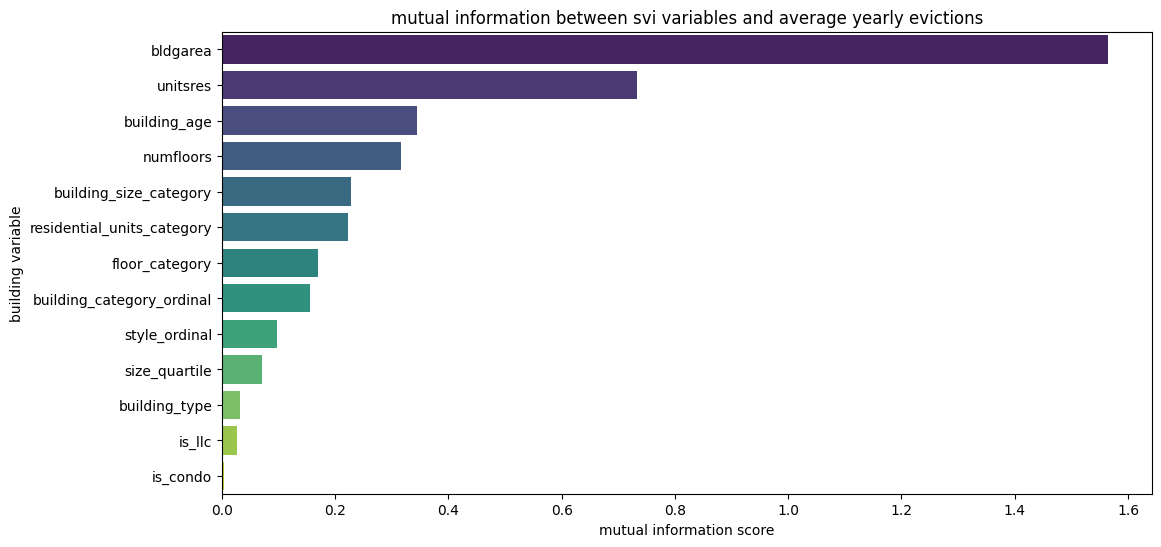

In [85]:
plt.figure(figsize=(12,6))
sns.barplot(data=mi_df, x='mi_scores', y='building_measurements', palette='viridis')
plt.title("mutual information between svi variables and average yearly evictions")
plt.xlabel("mutual information score")
plt.ylabel("building variable")
plt.show()

**Interestingly, 'building age' comes to the picture, and turns out to be a very good factor predicting the evictions. This is a feature that was not captured by the linear regression model. Why? A very simple explaination is the shape of the evictions over the ages of buildings might be U-shaped, where the ones during 20~50 might observe a lower eviction rate, while the younger (and therefore larger) buildings and very old buildings (also lager in size) might see more evictions.**

## **Part 2.3 Decision Tree Regression feature importance analysis**

**We use a decision tree regressor to rank building features by how much they reduce impurity in predicting eviction counts (again, works well for non-linear relationships and will be able to bring out the features that (multi)linear models didn't capture).**

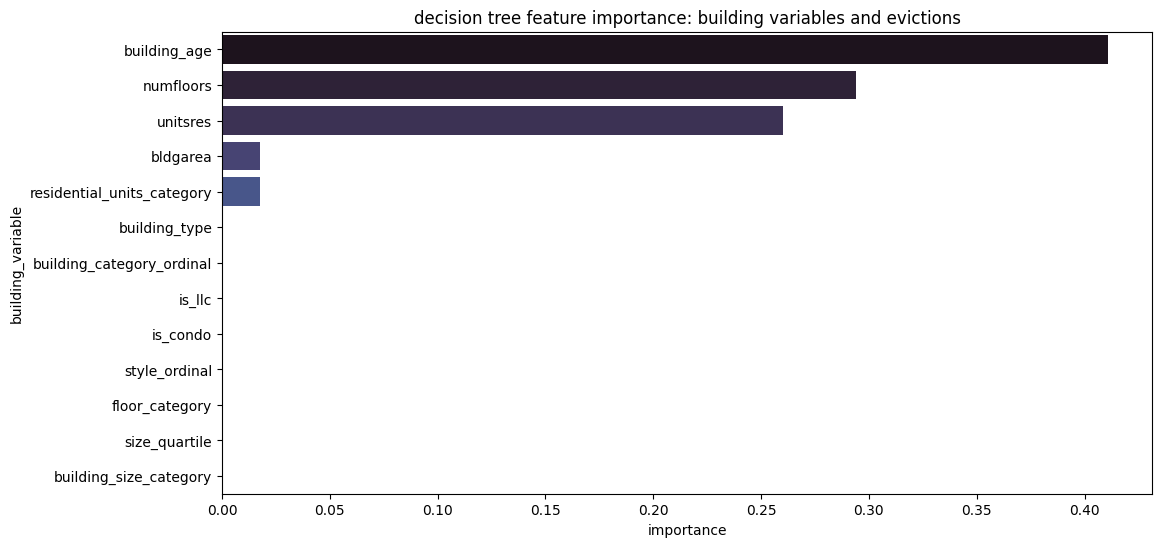

In [86]:
tree_model_building = DecisionTreeRegressor(max_depth=4)
tree_model_building.fit(X, y)
importances = tree_model_building.feature_importances_

imp_df = pd.DataFrame({'building_variable': new_building_vars, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=imp_df, x='importance', y='building_variable', palette='mako')
plt.title("decision tree feature importance: building variables and evictions")
plt.show()

**Very interestingly, here, the building age again poses as the most important factor. This means, the importance score shows how much the feature reduces prediction error (such as mse) across all splits in the tree. Since building_age ranking first, it shows the tree relies most heavily on age to partition the data effectively. Age creates splits that best separate high/low eviction cases.**

## **Part 2.4 RandomForestRegressor analysis.**

In [88]:
X = df_building[new_building_vars]
y = df_building['average_year_eviction_count']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
model_rfr_building = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_building.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [91]:
y_pred = model_rfr_building.predict(X_test)
df['predicted_eviction_count'] = model_rfr_building.predict(X)

In [92]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"mse {mse:.2f}, r square {r2:.2f}")
# much better predictive values than SVI

mse 1.33, r square 0.73


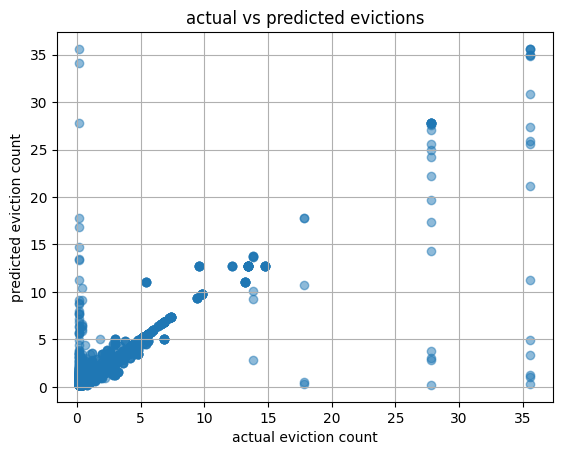

In [93]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("actual eviction count")
plt.ylabel("predicted eviction count")
plt.title("actual vs predicted evictions")
plt.grid(True)
plt.show()

**This shows the random forest regressor perform fairly well in predicting eviction counts with the building feature data, based on the trend in the graph and "mse 1.33, r square 0.73" stats results**

In [94]:
feat_importances = pd.Series(model_rfr_building.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

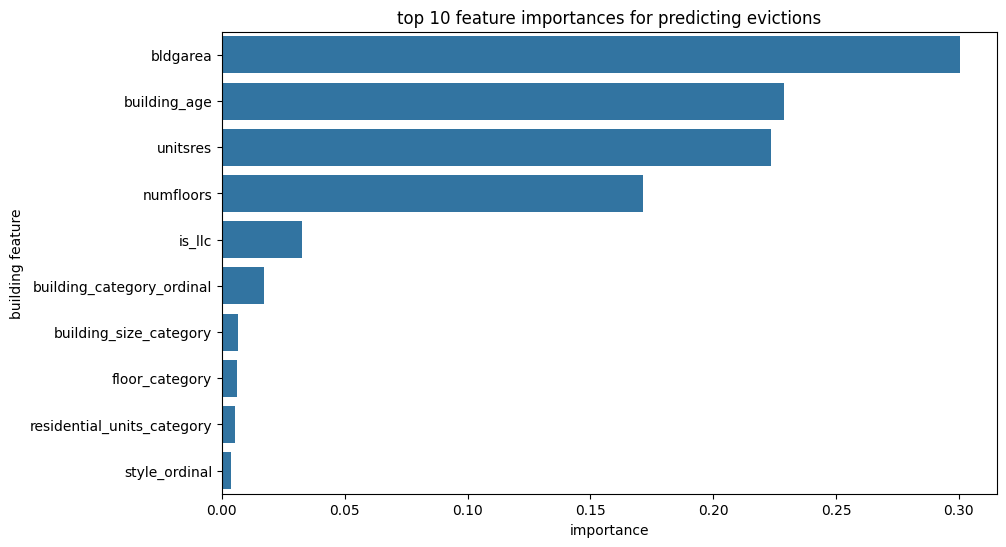

In [95]:
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values[:10], y=feat_importances.index[:10])
plt.title("top 10 feature importances for predicting evictions")
plt.xlabel("importance")
plt.ylabel("building feature")
plt.show()


In [96]:
top_features_idx = np.argsort(model_rfr_building.feature_importances_)[-10:]
top_features = [new_building_vars[i] for i in top_features_idx]

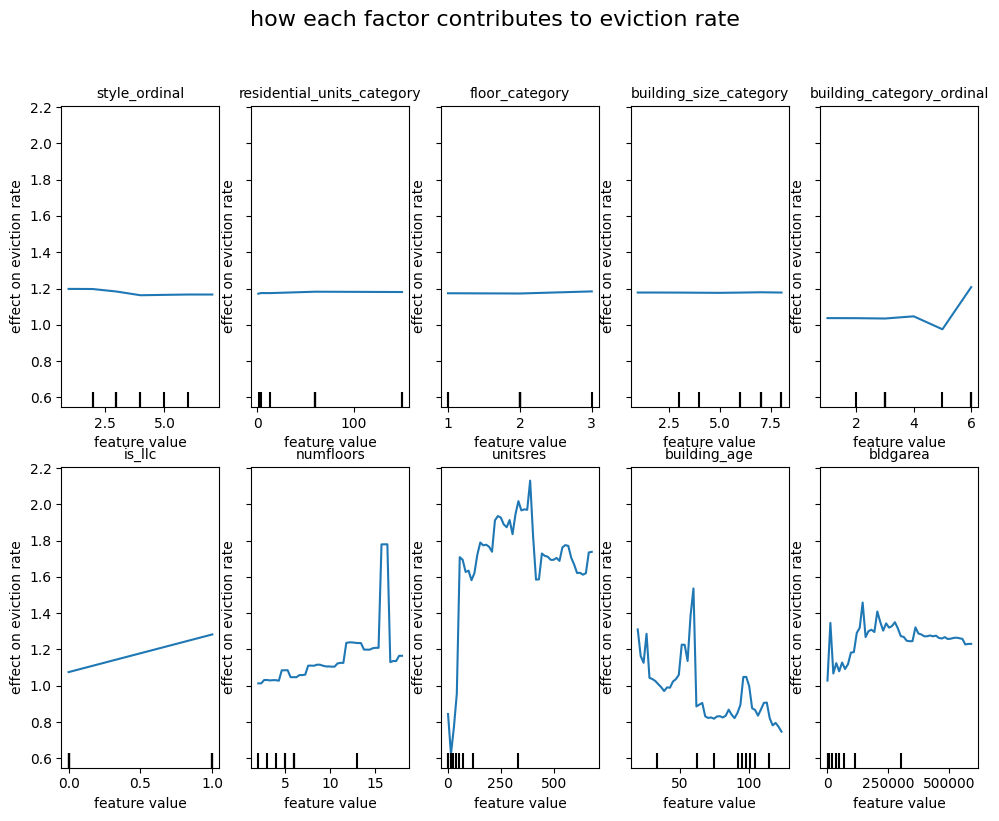

In [97]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_building,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

**Partial dependence from rfr: 1) features including unitres, numfloors, building_age, and is_llc are important predictors of eviction rate. 2) many categorical or ordinal variables like style_ordinal, floor_category, and residential_units_category don’t show strong effects, possibly due to low variability or weaker signal. 3) nonlinear relationships are captured well by random forests evidenced by spikes and dips in building_age and numfloors.**

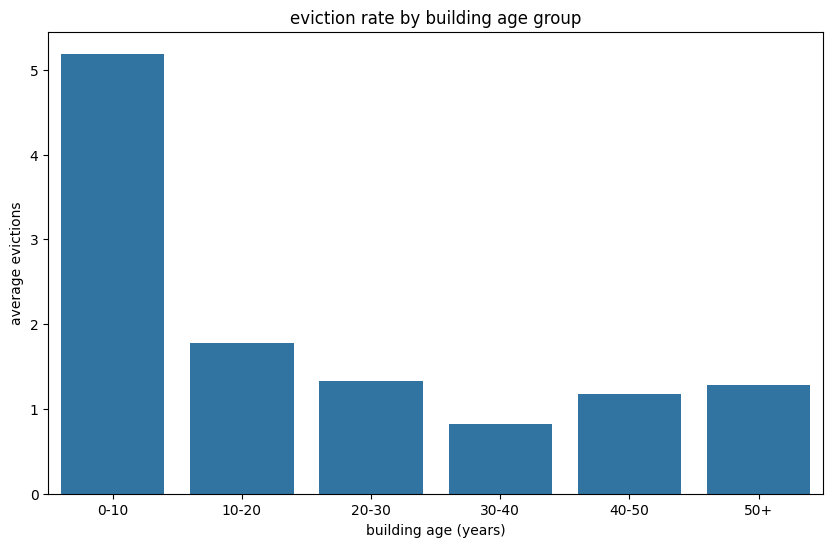

In [98]:
df_building['age_bin'] = pd.cut(df_building['building_age'],
                       bins=[0, 10, 20, 30, 40, 50, 100],
                       labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50+'])

plt.figure(figsize=(10, 6))
sns.barplot(x='age_bin', y='average_year_eviction_count', data=df_building, ci=None)
plt.title("eviction rate by building age group")
plt.xlabel("building age (years)")
plt.ylabel("average evictions")
plt.show()

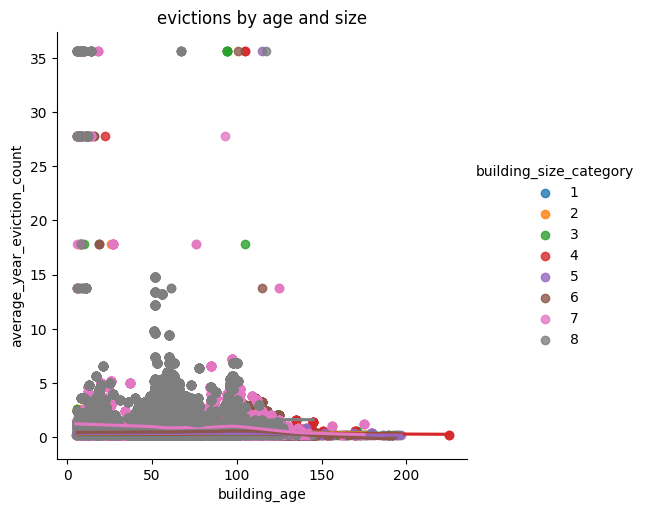

In [99]:
sns.lmplot(x='building_age', y='average_year_eviction_count',
           hue='building_size_category', data=df_building, lowess=True)
plt.title("evictions by age and size")
plt.show()
# based on this result, it is clear that larger buildings have higher eviction rates
# and buildings of age around 2~25, 45~75 (especially), 90~105, approximately have high average eviction rate.

In [100]:
# age_bins = df_building.groupby('age_bin').apply(lambda x: x[['building_age', 'average_year_eviction_count']].corr(method='spearman').iloc[0, 1])
# age_bins

In [101]:
df_building.building_size_category.unique()

array([3, 2, 4, 8, 7, 6, 5, 1])

<Axes: xlabel='age_group', ylabel='average_year_eviction_count'>

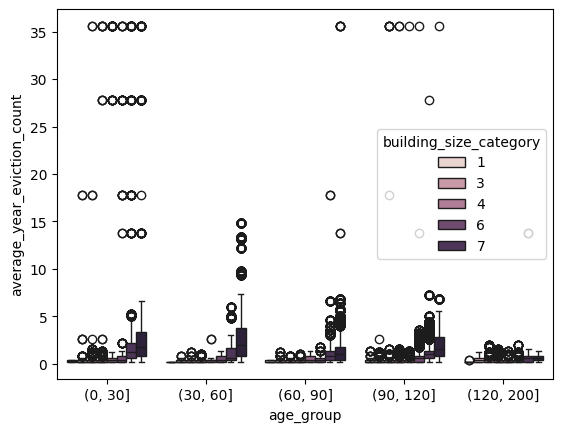

In [102]:
df_building['age_group'] = pd.cut(df_building['building_age'], bins=[0, 30, 60, 90, 120, 200])
sns.boxplot(x='age_group', y='average_year_eviction_count', hue='building_size_category', data=df_building)
# in any age group, larger buildings experience way more evictions

In [103]:
df_building['age_group'] = pd.cut(df_building['building_age'], bins=[0, 30, 60, 90, 120, 200])

In [104]:
grouped = df_building.groupby(['age_group', 'building_size_category'])

In [105]:
eviction_stats_list = []

In [107]:
# loop through each group and build a dataframe.
for (age_group, size_category), group in grouped:
    total = len(group)
    count_eviction_5 = (group['average_year_eviction_count'] > 5).sum()
    top_10_percent = group['average_year_eviction_count'].quantile(0.9)
    count_top_10 = (group['average_year_eviction_count'] >= top_10_percent).sum()
    percent_gt_5 = 100 * count_eviction_5/total if total > 0 else 0
    percent_top_10 = 100 * top_10_percent/total if total > 0 else 0

    eviction_stats_list.append({
        'age_group': age_group,
        'building_size_category': size_category,
        'total_buildings': total,
        'count_eviction_gt_5': count_eviction_5 ,
        'percent_eviction_gt_5': percent_gt_5,
        'top_10_percent_threshold': top_10_percent,
        'count_in_top_10_percent': count_top_10,
        'percent_in_top_10_percent': percent_top_10
    })

In [108]:
eviction_stats_df = pd.DataFrame(eviction_stats_list)
eviction_stats_df
# confirmed

,age_group,building_size_category,total_buildings,count_eviction_gt_5,percent_eviction_gt_5,top_10_percent_threshold,count_in_top_10_percent,percent_in_top_10_percent
0,"(0, 30]",1,4,0,0.000000,0.40,2,10.000000
1,"(0, 30]",2,344,2,0.581395,0.60,57,0.174419
2,"(0, 30]",3,819,4,0.488400,0.64,82,0.078144
3,"(0, 30]",4,714,8,1.120448,0.60,132,0.084034
4,"(0, 30]",5,419,33,7.875895,1.00,69,0.238663
5,"(0, 30]",6,401,22,5.486284,1.20,52,0.299252
6,"(0, 30]",7,2146,105,4.892824,3.80,216,0.177074
7,"(0, 30]",8,1627,156,9.588199,5.00,181,0.307314
8,"(30, 60]",1,7,0,0.000000,0.20,7,2.857143
9,"(30, 60]",2,190,0,0.000000,0.40,66,0.210526


In [109]:
import statsmodels.api as sm
model = sm.OLS.from_formula('average_year_eviction_count ~ building_age * building_size_category', data=df_building).fit()
print(model.summary())

# linear model is not capturing much of the variability in eviction count — even particularly with building age and size category included
# but it makes sense.
# most buildings have 0 or very low eviction counts and a few buildings have very high values so we have the long-tailed distribution.
# but linear regression usually assumes normally distributed residuals, which is not hold here.
# and as the pretty good tree-based model results suggest, eviction patterns might follow thresholds, splits
# (e.g., evictions spike only in size 7+ and age < 60), but not smooth linear relationships.
# so a linear model can't capture this well.

                                 OLS Regression Results                                
Dep. Variable:     average_year_eviction_count   R-squared:                       0.116
Model:                                     OLS   Adj. R-squared:                  0.115
Method:                          Least Squares   F-statistic:                     2890.
Date:                         Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                                 04:26:59   Log-Likelihood:            -1.4437e+05
No. Observations:                        66397   AIC:                         2.887e+05
Df Residuals:                            66393   BIC:                         2.888e+05
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

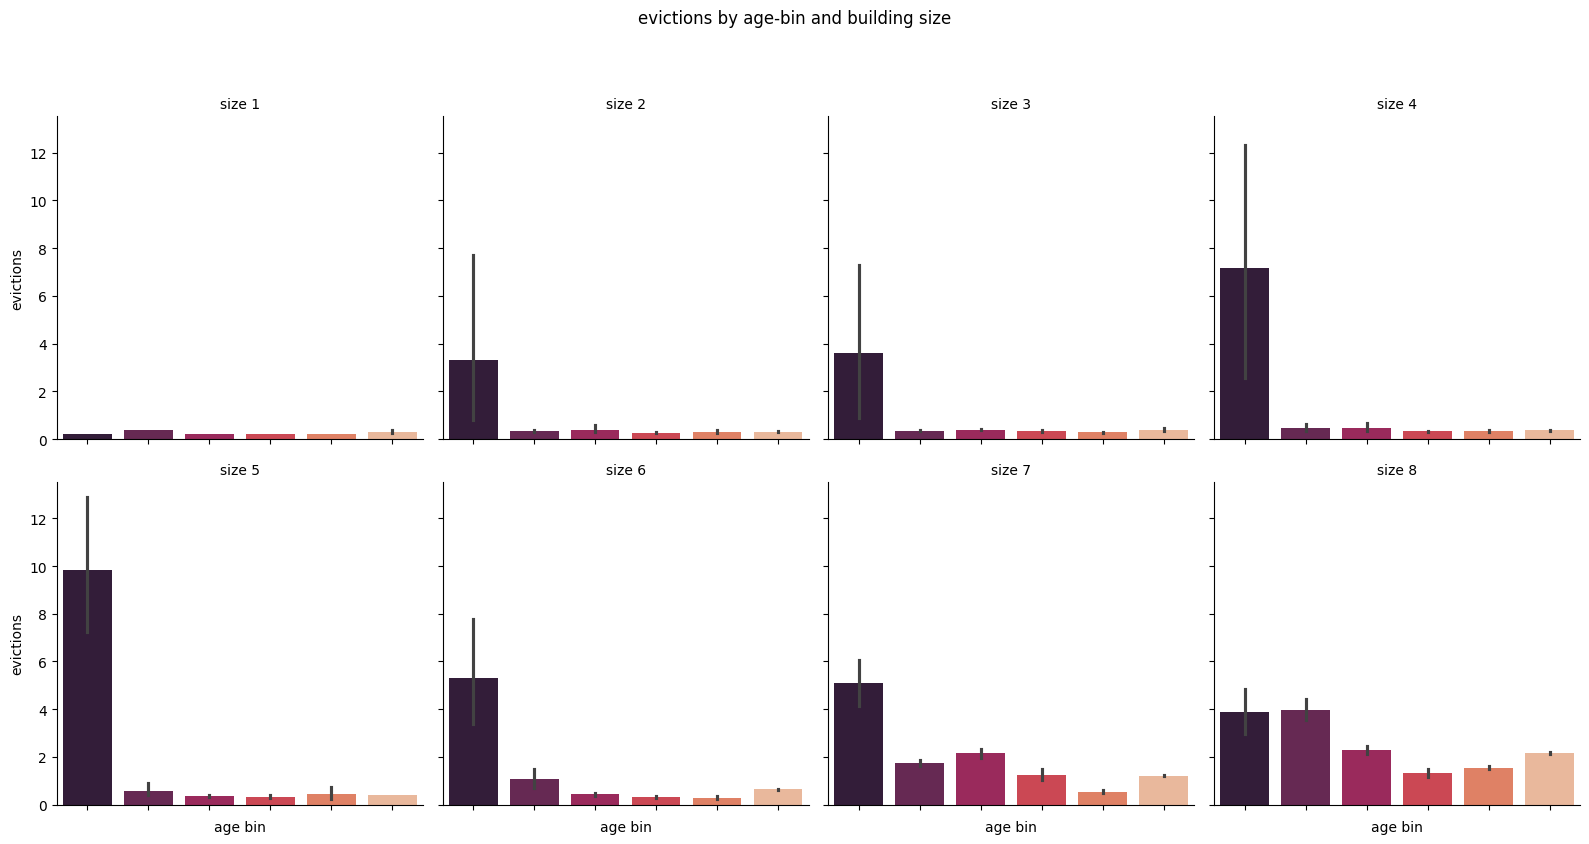

In [110]:
# cacet grid by size category combining building size and building age
g = sns.FacetGrid(df_building, col='building_size_category', col_wrap=4, height=4)
g.map_dataframe(sns.barplot, x='age_bin', y='average_year_eviction_count', palette='rocket', ci=95)
g.set_titles("size {col_name}")
g.fig.suptitle("evictions by age-bin and building size", y=1.05)
g.set_axis_labels("age bin", "evictions")
[ax.set_xticklabels(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
plt.tight_layout()
# what this result shows is 1) older buildings are more eviction-prone, especially in mid-to-large size categories.
# 2) larger buildings (sizes 5–8) tend to have more evictions overall, with the highest concentrations in the oldest buildings.
# 3) the smaller buildings show very little eviction activity, regardless of age.

### **Evictions cluster in large, old buildings — suggesting structural and institutional risks beyond poverty or tenant complaints. These buildings may be key targets for proactive policy interventions.**

In [ ]:
# df_building['is_old_large_building'] = (df_building['age_bin'] == 'Pre-War') & (df_building['building_size_category'].isin([5,6,7,8]))

In [ ]:
# df_building['age_size_interaction'] = df_building['building_size_category'] * df_building['age_bin'].cat.codes

In [ ]:
# df_building['is_old_large_building'].mean()
# # % of buildings that fall into this category
# df_building.groupby('is_old_large_building')['average_year_eviction_count'].mean()

In [ ]:
# sns.boxplot(data=df_building, x='is_old_large_building', y='average_year_eviction_count')
# plt.title("eviction rate by old large building status")

In [ ]:
print(list(df_building.columns))

# **Part 3: Check linearity and Tree-based nonlinear models with eviction rates and 311 complaints**

## **Part 3.1 Spearsman rank correlation: good for detecting and measuring monotonic relationships even if not linear nor normally distributed.**

In [111]:
df_311 = df_building.copy()

In [112]:
df.columns

Index(['primary_key', 'bbl', 'court_index_number', 'docket_number',
       'eviction_address', 'eviction_apartment_number', 'executed_date',
       'borough', 'zipcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'nta', 'year', 'month_year', 'geometry',
       'average_year_eviction_count', 'yearbuilt', 'bldgclass', 'numfloors',
       'unitsres', 'ownername', 'bldgarea', 'building_type',
       'building_category', 'is_condo', 'floor_category', 'rent_era',
       'architectural_style', 'economic_period', 'residential_units_category',
       'is_llc', 'building_size_category', 'size_quartile', 'decade', 'fips',
       'e_totpop', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4',
       'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
       'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh',
       'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian',

In [113]:
complaints_vars = ['air_quality', 'animal_issues', 'appliances', 'building_exterior', 'doors_windows',
       'electrical_issues', 'elevator_issues', 'floors_stairs',
       'general_complaints', 'graffiti_posting', 'heat_hot_water',
       'homeless_issues', 'noise_complaints', 'other_issues', 'pest_issues',
       'plumbing_issues', 'police_matters', 'public_nuisance',
       'safety_concerns', 'sanitation_issues', 'walls_ceilings',
       'total_complaints']

In [114]:
# comlaints_vars

In [115]:
df_311[complaints_vars].head()
# all numeric columns, except the frequency counts and the label encoding ones, as they are not suitable for linear
# regression anyways. Will be utilized in other places later.

,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints
0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,5.0,19.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0
2,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0
3,6.0,0.0,0.0,0.0,9.0,0.0,2.0,5.0,5.0,0.0,23.0,0.0,145.0,0.0,2.0,41.0,0.0,0.0,1.0,5.0,4.0,248.0
4,0.0,5.0,8.0,0.0,21.0,8.0,34.0,10.0,9.0,0.0,89.0,0.0,78.0,0.0,5.0,41.0,1.0,0.0,3.0,31.0,13.0,356.0


In [116]:
check_nan = df_311[['average_year_eviction_count'] + complaints_vars].isna().sum()
check_nan
# just in case, check nans

,0
average_year_eviction_count,0
air_quality,0
animal_issues,0
appliances,0
building_exterior,0
doors_windows,0
electrical_issues,0
elevator_issues,0
floors_stairs,0
general_complaints,0


In [117]:
target_and_features = ['average_year_eviction_count'] + complaints_vars
df_spearman = df_311[target_and_features].copy()

In [118]:
spearman_corr = df_spearman.corr(method='spearman')['average_year_eviction_count'].sort_values(ascending=False)
spearman_corr

,average_year_eviction_count
average_year_eviction_count,1.000000
total_complaints,0.627602
plumbing_issues,0.619779
sanitation_issues,0.618566
walls_ceilings,0.590176
doors_windows,0.584301
heat_hot_water,0.580785
general_complaints,0.558923
appliances,0.544444
floors_stairs,0.541637


In [119]:
# df_spearman = df_building['average_year_eviction_count'] + df_building[new_building_vars]
# # this line would use up ram very quickly,because this is creating unnecessary intermediate DataFrames when concatenating columns
# # not the correct way to combine columns (it tries to add values instead of merging columns).

In [120]:
# df[new_building_vars].head()
# # all numeric values

In [121]:
corr_matrix = df_spearman.corr(method='spearman')

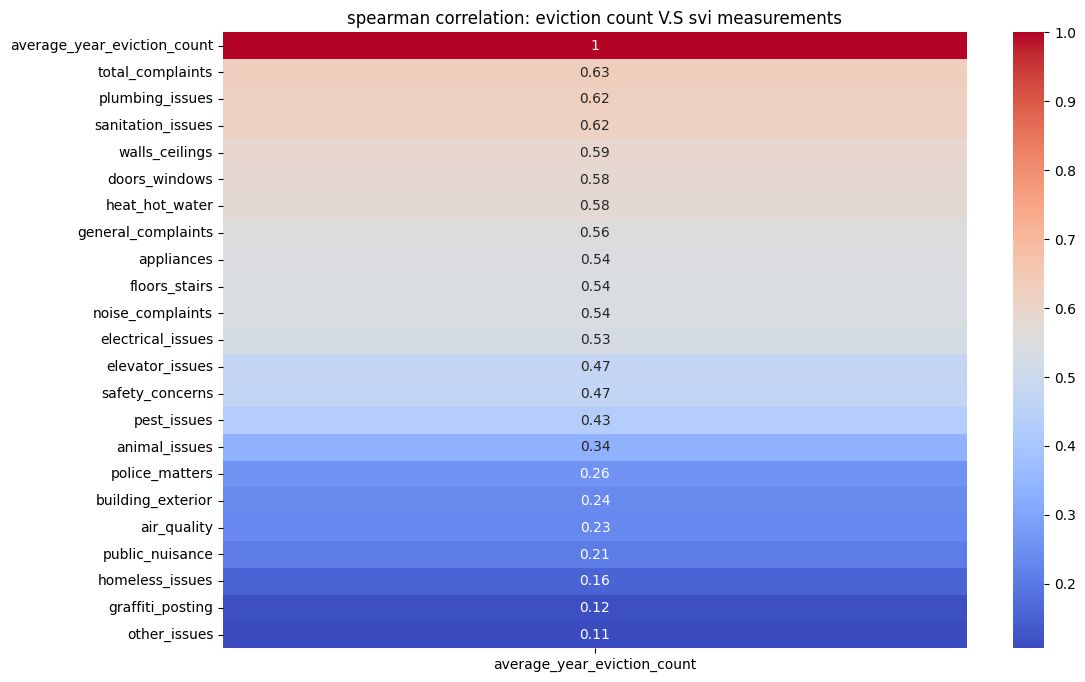

In [122]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['average_year_eviction_count']].sort_values(by='average_year_eviction_count', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count V.S svi measurements')
plt.show()
# important
# very good scores

**strong positive correlations (0.5 and above)**
These factors are most associated with higher eviction rates:
unitsres (0.57): More residential units -->  higher evictions. \
bldgarea (0.56): Larger building area --> higher evictions. \
building_size_category (0.56): Bigger buildings --> higher evictions. \
residential_units_category (0.55): More units --> Higher evictions. \
numfloors (0.53): Taller buildings --> Higher evictions. \

**Short summaries**:

Nohing really suprising here, as previously known, we need to focus on large, multi-unit residential buildings for eviction prevention programs.

**moderate Positive Correlations (0.3–0.5)**
floor_category (0.5): Higher floors --> slightly more evictions. \
building_category_ordinal (0.45): certain building types (e.g., elevators) --> more evictions. \
size_quartile (0.34): Larger size quartiles --> mildly higher evictions. \

note: some of these columns actually point to the same thing, since there was no large discrepency here, it is fairly reasonable to say larger, taller buildings have more evictions.  \

**However, this is just the linear regression analysis. What if there are fatcors not captured by this test?**

**Part 3.2 Tree-based model: we use mutural information scores (mis): measuring non-linear dependencies between features, and is good for discovering how much information one variable gives about another.**

In [123]:
X = df_311[complaints_vars]
y = df_311['average_year_eviction_count']

mi_scores = mutual_info_regression(X, y)

In [124]:
mi_df = pd.DataFrame({'building_measurements': complaints_vars, 'mi_scores': mi_scores})
mi_df = mi_df.sort_values(by='mi_scores', ascending=False)

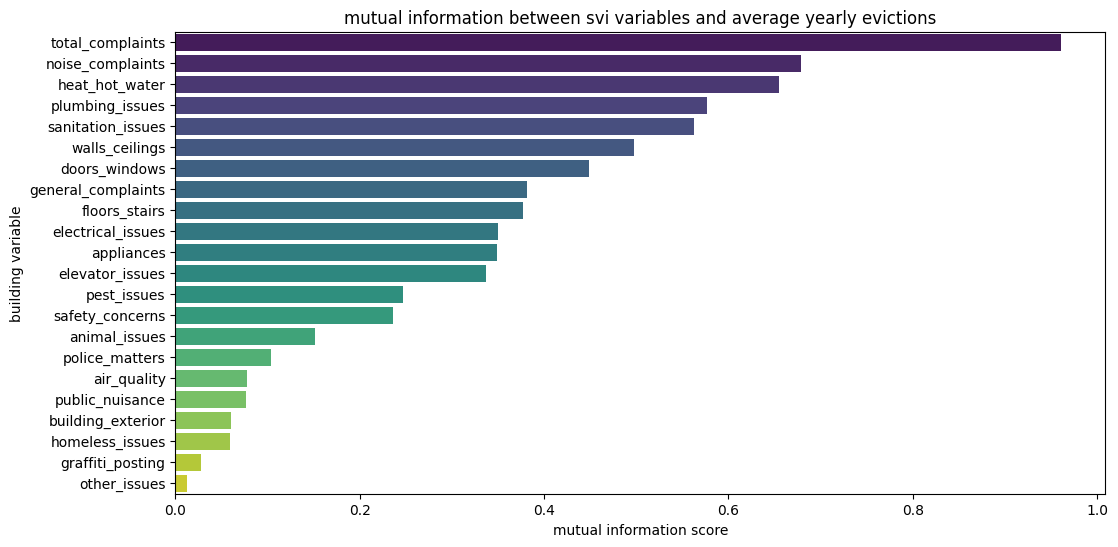

In [125]:
plt.figure(figsize=(12,6))
sns.barplot(data=mi_df, x='mi_scores', y='building_measurements', palette='viridis')
plt.title("mutual information between svi variables and average yearly evictions")
plt.xlabel("mutual information score")
plt.ylabel("building variable")
plt.show()

**Interestingly, 'building age' comes to the picture, and turns out to be a very good factor predicting the evictions. This is a feature that was not captured by the linear regression model. Why? A very simple explaination is the shape of the evictions over the ages of buildings might be U-shaped, where the ones during 20~50 might observe a lower eviction rate, while the younger (and therefore larger) buildings and very old buildings (also lager in size) might see more evictions.**

## **Part 3.3 Decision Tree Regression feature importance analysis**

**We use a decision tree regressor to rank building features by how much they reduce impurity in predicting eviction counts (again, works well for non-linear relationships and will be able to bring out the features that (multi)linear models didn't capture).**

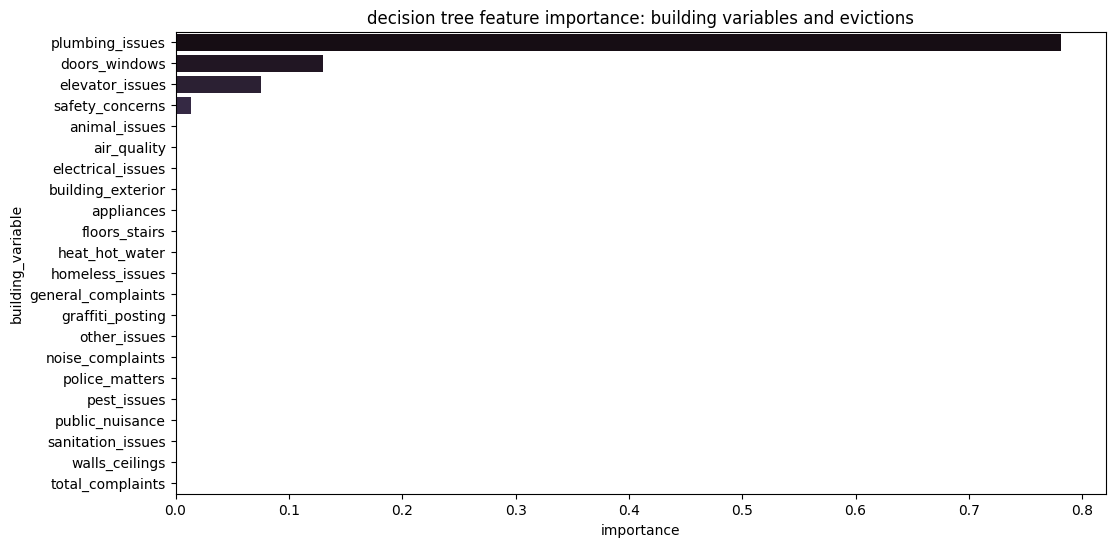

In [126]:
tree_model_311 = DecisionTreeRegressor(max_depth=4)
tree_model_311.fit(X, y)
importances = tree_model_311.feature_importances_

imp_df = pd.DataFrame({'building_variable': complaints_vars, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=imp_df, x='importance', y='building_variable', palette='mako')
plt.title("decision tree feature importance: building variables and evictions")
plt.show()

In [127]:
# features = [df_building.columns.get_loc('building_age')]
# PartialDependenceDisplay.from_estimator(tree_model, df, features=features)
# plt.title("partial dependence of evictions on building Age")
# plt.show()
# # for some reasons, the age was not a factor to the model at all.

**Very interestingly, here, the building age again poses as the most important factor. This means, the importance score shows how much the feature reduces prediction error (such as mse) across all splits in the tree. Since building_age ranking first, it shows the tree relies most heavily on age to partition the data effectively. Age creates splits that best separate high/low eviction cases.**

## **Part 3.4 RandomForestRegressor analysis.**

In [128]:
X = df_311[complaints_vars]
y = df_311['average_year_eviction_count']

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
model_rfr_311 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_311.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [131]:
y_pred = model_rfr_311.predict(X_test)
df['predicted_eviction_count'] = model_rfr_311.predict(X)

In [132]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"mse {mse:.2f}, r square {r2:.2f}")
# actually good, better than svi
# 1.33, 0.73 for building features

mse 1.55, r square 0.68


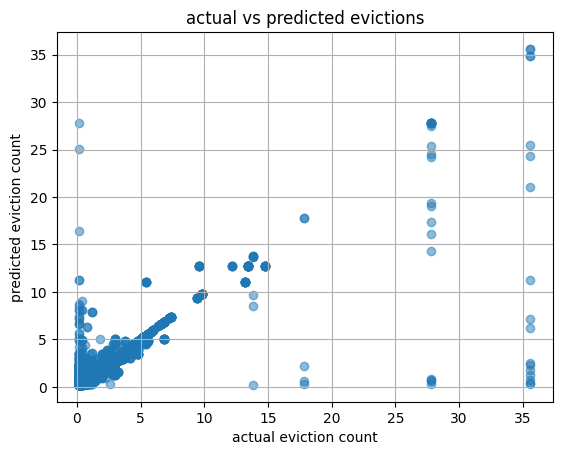

In [133]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("actual eviction count")
plt.ylabel("predicted eviction count")
plt.title("actual vs predicted evictions")
plt.grid(True)
plt.show()

**This shows the random forest regressor perform fairly well in predicting eviction counts with the building feature data, based on the trend in the graph and "mse 1.55, r square 0.68" stats results**

In [136]:
feat_importances = pd.Series(model_rfr_311.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

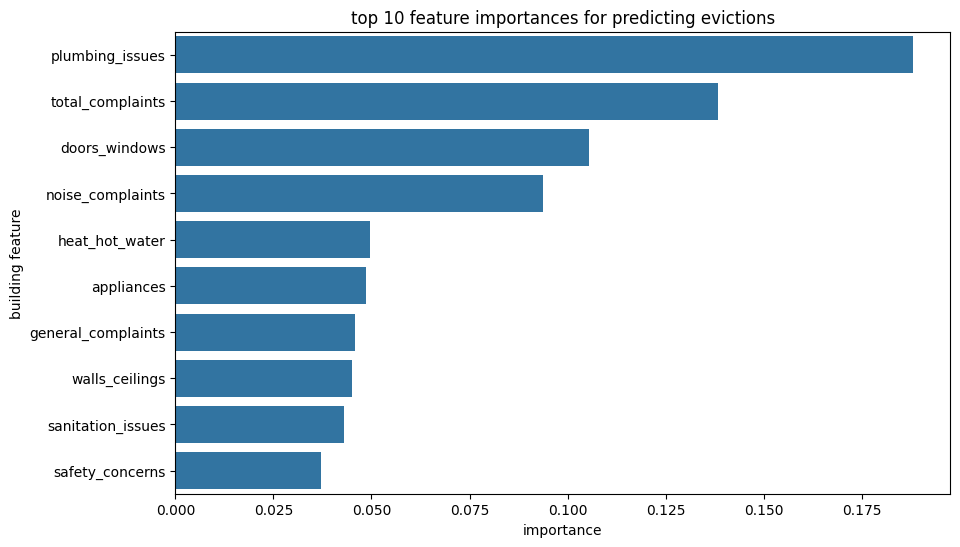

In [137]:
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values[:10], y=feat_importances.index[:10])
plt.title("top 10 feature importances for predicting evictions")
plt.xlabel("importance")
plt.ylabel("building feature")
plt.show()

In [138]:
top_features_idx = np.argsort(model_rfr_311.feature_importances_)[-10:]
top_features = [complaints_vars[i] for i in top_features_idx]

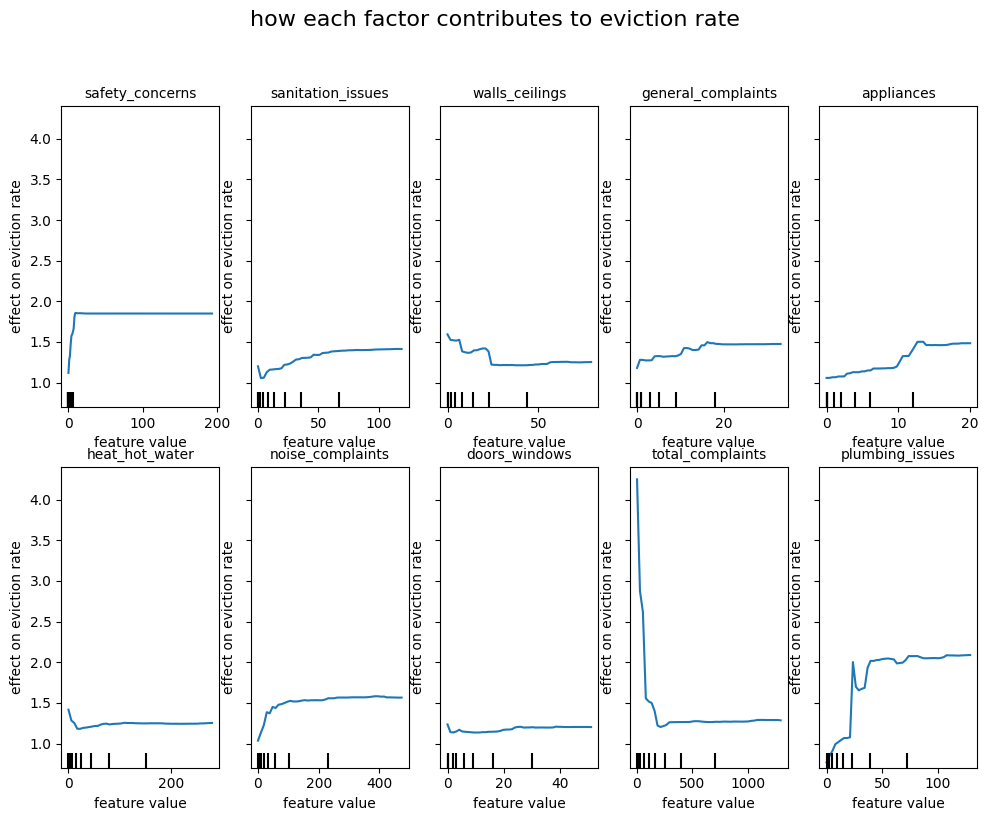

In [139]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_311,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

**complaint volume and types matter: certain complaint categories, especially heat/hot water, plumbing, noise, and total volume, are strong predictors of eviction likelihood. However, not all complaints are treated equally: some such as walls/ceilings or windows, are less predictive, possibly seen as less urgent.Threshold also matters: a small number of serious complaints can dramatically increase risk (such as heat/hot water), suggesting landlords may respond with eviction to avoid legal consequences or repair costs.**

### **Why shap and feature_importance results will differ?**

Shap analysis is based on simulating removing and adding each feature to the prediction (by the random forest regressor model for every sample) and determine the features and rank them.

feature_importance is showing/ranking the features by where and how often a feature is used to split in the trees

But for our purposes (to identify the top important features), we just need to locate the ones that overlap in both groups.

In [142]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_311.predict, X)

PermutationExplainer explainer: 501it [02:47,  2.81it/s]


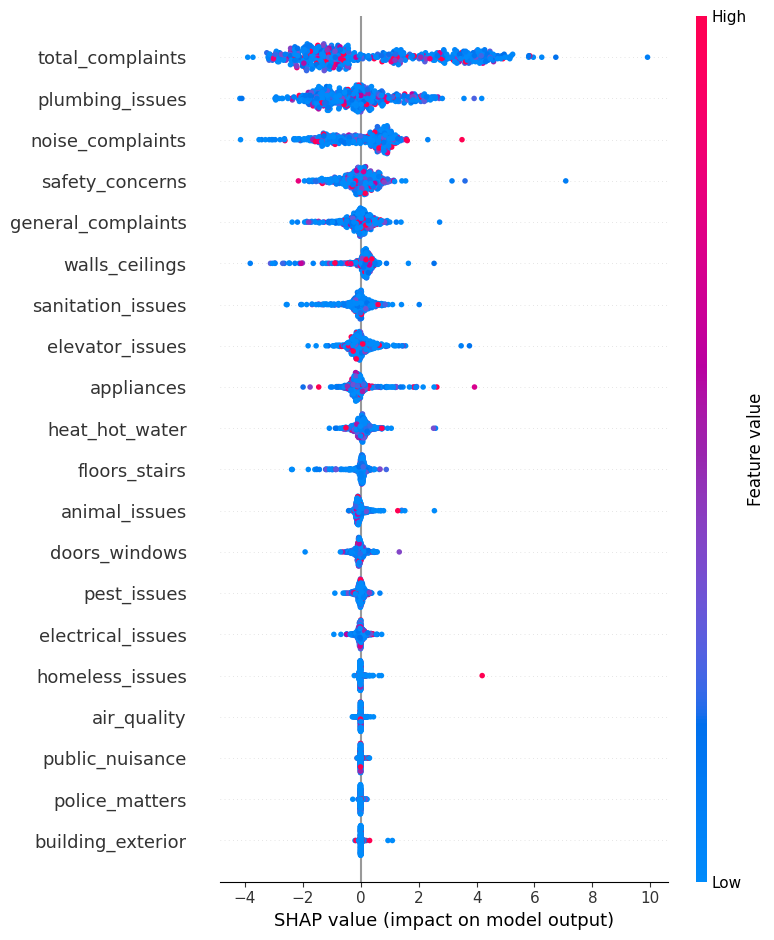

In [146]:
# explainer = shap.TreeExplainer(model_rfr_311.predict)
explainer = shap.Explainer(model_rfr_311.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

In [147]:
len(list(df_311.columns)), len(list(df_building.columns)), len(list(df_svi.columns))
# df_311 didn't really change anything to the copy of df_building, as everything was already in numeric

(101, 101, 93)

In [149]:
df_311.shape, df_raw.shape

((66397, 101), (66397, 92))

In [ ]:
df_311.to_csv('/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times_analysis.csv')

### full shap analysis is in the next notebook for brevity. 